# MHKiT Power Module  
The following example uses the [MHKiT power module](https://mhkit-software.github.io/MHKiT/mhkit-python/api.power.html) to compute power, instantaneous frequency, and harmonics from time-series of voltage and current. 

Start by importing the necessary python packages and MHKiT module.

In [1]:
import numpy as np
import pandas as pd
from mhkit import power, utils

## Load Power Data
We will begin by reading in time-series data of measured three phase (a, b, and c) voltage and current. 

Note: IEC TS 62600-30 requires power quality assessments on a minimum of 10 minute time-series data, but for this example a shorter time-series is used. 


In [2]:
# Read in time-series data of voltage (V) and current (I)
power_data = pd.read_csv('data/2020224_181521_PowRaw.csv',skip_blank_lines=True,index_col='Time_UTC') 
# Convert the time index to type "datetime" 
power_data.index=pd.to_datetime(power_data.index)
# Display the data
power_data.head()

,MODAQ_Va_V,MODAQ_Vb_V,MODAQ_Vc_V,MODAQ_Ia_I,MODAQ_Ib_I,MODAQ_Ic_I
Time_UTC,,,,,,
2020-02-24 18:15:21.499998208,10652.764496,-8499.446320,-1850.166138,-23.213654,19.219666,4.023438
2020-02-24 18:15:21.500018208,10691.122620,-8428.702576,-1927.626526,-23.404846,19.181671,4.289856
2020-02-24 18:15:21.500038209,10732.961151,-8364.997162,-2001.269318,-23.493042,19.033966,4.478912
2020-02-24 18:15:21.500058210,10775.892639,-8304.582245,-2071.241791,-23.680115,18.917847,4.858246
2020-02-24 18:15:21.500078210,10818.297028,-8248.074066,-2138.016785,-23.737946,18.702087,5.092468


## Power Characteristics 
The `power.characteristics` submodule is used to compute quantities of interest from voltage and current time-series. In this example, we will calculate active AC power and instantneous frequency.

### Active AC Power
To compute the active AC power, the user must provide a `power_factor` for the efficency of the device. 


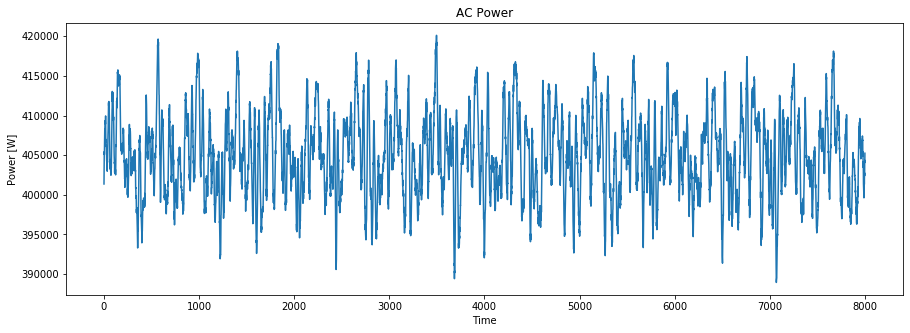

In [3]:
# First seperate the voltage and current time-series into seperate dataFrames
voltage = power_data[['MODAQ_Va_V', 'MODAQ_Vb_V', 'MODAQ_Vc_V']]
current = power_data[['MODAQ_Ia_I','MODAQ_Ib_I','MODAQ_Ic_I']]

# Set the power factor for the system
power_factor = 0.96 

# Compute the instantaneous AC power in watts
ac_power = power.characteristics.ac_power_three_phase(voltage, current, power_factor) 
# Display the result
ac_power.Power.plot(figsize=(15,5),title='AC Power').set(xlabel='Time',ylabel='Power [W]');

### Instantaneous Frequency

Calculate the instantaneous frequency of the voltage time-series using the 3 phase voltage measurements. The time-varying instantaneous frequency is a required metric for power quality assessments. 

      MODAQ_Va_V   MODAQ_Vb_V   MODAQ_Vc_V
1     902.215367  1218.092331   433.063162
2       8.499136    12.753006    28.996487
3     509.904722   671.800108   268.237845
4      10.176332    15.101179    26.504936
5     399.622022   524.697779   217.596577
...          ...          ...          ...
7995  409.417092   283.666234   590.349442
7996    8.595995    37.346047    25.635873
7997  525.506488   345.489184   757.187883
7998    7.418581    32.652670    22.526498
7999  944.234501   569.696896  1386.205704

[7999 rows x 3 columns]


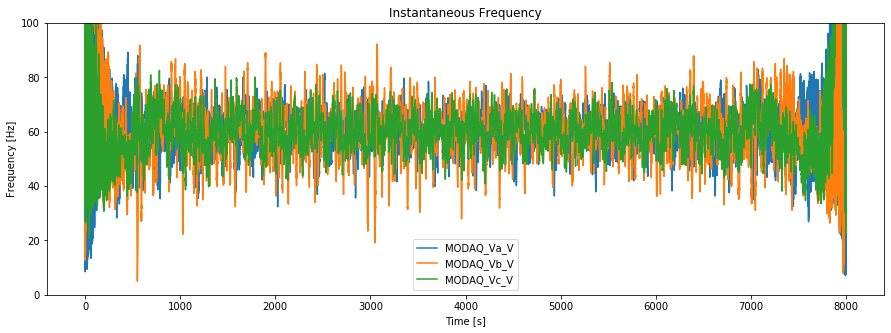

In [6]:
# Compute the instantaneous frequency
inst_freq = power.characteristics.instantaneous_frequency(voltage) 
print(inst_freq)

# Display the result
inst_freq.plot(figsize=(15,5), ylim=(0,100),
               title='Instantaneous Frequency').set(xlabel='Time [s]',
                                                    ylabel='Frequency [Hz]');

## Power Quality
The `power.quality` module can be used to compute harmonics of current. and voltage and current distortions following IEC/TS 62600-30 and IEC/TS 61000-4-7. Harmonics and harmonic distortion are required as part of a power quality assessment and characterize the stability of the produced power. 

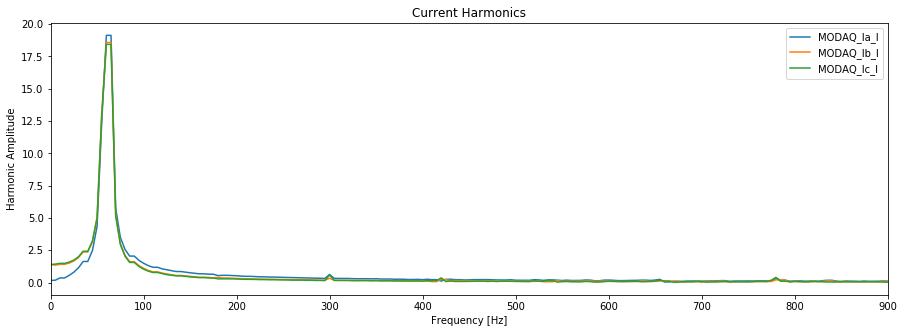

In [10]:
# Set the nominal sampling frequency
sample_freq = 50000   #[Hz]

# Set the frequency of the grid the device would be conected to
grid_freq = 60        #[Hz] 

# Set the rated current of the device
rated_current = 18.8  # [Amps]

# Calculate the harmonics
harmonics = power.quality.harmonics(current, sample_freq, grid_freq)

# Display the results
harmonics.plot(figsize=(15,5),xlim=(0,900),
               title='Current Harmonics').set(ylabel='Harmonic Amplitude',
                                              xlabel='Frequency [Hz]');


### Harmonic Subgroups
Describe what the subgroups are and why we want to calculate them

The harmonic subgroups calculations are based on IEC/TS 62600-30. We can calculate them using our grid frequency and harmonics.

In [8]:
# Calcualte Harmonic Subgroups
h_s = power.quality.harmonic_subgroups(harmonics,grid_freq) 
# Display the results
h_s.head()

,MODAQ_Ia_I,MODAQ_Ib_I,MODAQ_Ic_I
0,0.247401,1.948879,1.991755
60,29.761108,29.305038,29.127020
120,1.870176,1.291483,1.206478
180,1.007562,0.648012,0.535090
240,0.727466,0.437456,0.370414


### Total Harmonic Current Distortion

Compute the THCD from harmonic subgroups and rated current for the device

In [9]:
#Finally we can compute the total harmonic current distortion as a percentage 
THCD=power.quality.total_harmonic_current_distortion(h_s,rated_current) 
print('Channel         THCD')
print('----------------------')
print(THCD.to_string())

Channel         THCD
----------------------
MODAQ_Ia_I    8.972511
MODAQ_Ib_I    6.096617
MODAQ_Ic_I    5.929491
